# Defining Catchment Areas
We defined catchment areas by assigning census tracts to the agency distribution sites. The census tract data was downloaded from http://data.sandiegodata.org/dataset/san-diego-census-tracts. We used simple straight line distance from the given latitude and longitude of the census tracts, to the latitude and longitude of each of the agency distribution sites to assign the catchment areas. We investigated using a more complex distance calculation, namely 

In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


### Load census tract data

In [3]:
#the file I downloaded from http://data.sandiegodata.org/dataset/san-diego-census-tracts, then dropped the airport tract
sd_data = pd.read_csv('sandiegocensustract.csv', index_col=0)

In [4]:
sd_data.reset_index(drop=True,inplace=True)
sd_data.head()

,TRACTNUM,TRACT,SevCrwd,TeenBirthProportion,TeenBirthAllWom,SingMother,MaltrtAllegRate,FosterCareEntry,TotalPov,ChildPov,...,PovertyPctl,Unemployment,UnemploymentPctl,PopCharScore,PopCharPctl,NeighborhoodName,n_FoodDesert,pct_FoodDesert,LiqCount,Uninsured
0,6073005000,50.00,0.110,0.127273,0.014028,0.141199,157.899990,8.1,42.799999,45.900002,...,96.646072,NaN,NaN,8.316532,95.146118,Barrio Logan,160.950368,0.210393,556.75000,0.226247
1,6073020028,200.28,0.118,0.074468,0.006250,0.221421,NaN,0.0,41.000000,50.200001,...,95.069979,4.31,5.174611,5.724663,59.814374,San Marcos,920.544771,0.700034,NaN,0.190999
2,6073004501,45.01,0.056,0.700000,0.039019,0.048000,24.400000,1.9,17.500000,25.600000,...,72.336401,5.66,11.534540,4.997402,47.811363,Golden Hill,0.000000,0.000000,958.33331,0.144167
3,6073004800,48.00,0.151,0.000000,0.000000,0.198259,79.599998,0.8,33.400002,39.799999,...,95.536502,10.62,51.452970,7.884312,91.270538,Grant Hill,0.000000,0.000000,1028.75000,0.137367
4,6073003601,36.01,0.016,0.000000,0.000000,0.317631,86.000000,4.1,25.900000,33.599998,...,97.503467,17.84,88.592914,8.367767,95.735608,South Crest,423.198652,0.355928,1625.00000,0.136549


In [5]:
sd_data.head()[['TRACT', 'TRACTNUM']]

,TRACT,TRACTNUM
0,50.00,6073005000
1,200.28,6073020028
2,45.01,6073004501
3,48.00,6073004800
4,36.01,6073003601


### Load agency sites

In [6]:
agency_data = pd.read_csv('agency_master_geocoded.csv')

In [7]:
agency_loc = agency_data[['Agency #', 'Agency Name', 'Latitude', 'Longitude']]

In [8]:
agency_loc.dropna(inplace=True)
agency_loc.reset_index(drop=True,inplace=True)
agency_loc.head()

/Users/jfly/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Agency #,Agency Name,Latitude,Longitude
0,1306,31st St. SDA Church,32.702025,-117.127443
1,1318,Alpine Community Center,32.837626,-116.774913
2,1044,Amity Foundation,33.165122,-117.222261
3,1002,Angel's Depot,33.136002,-117.223964
4,1078,Bayside Community Center,32.783125,-117.172847


### Calculate distances
Defining generic functions that determine catchment areas given an abstracted distance formula

In [10]:
import time

def get_cost_matrix(rows, row_labels, cols, col_labels, cost_function, sleep_sec=0):
    row_col_costs = []
    for i in xrange(len(rows)):
        temp_costs = []
        pt_1 = (rows[row_labels[0]][i], rows[row_labels[1]][i])
        for j in xrange(len(cols)):
            pt_2 = (cols[col_labels[0]][j], cols[col_labels[1]][j])
            temp_costs.append(cost_function(pt_1, pt_2))
            time.sleep(sleep_sec)
        row_col_costs.append(pd.Series(temp_costs))
        if i%5==0: print i,'\r',
    return row_col_costs


In [11]:
def get_catchment_groups(tracts, agencies, cost_function, sleep_sec=0):
    full_cost_matrix = get_cost_matrix(tracts, ('Latitude','Longitude'), agencies, ('Latitude', 'Longitude'), cost_function, sleep_sec)
    df_cost_matrix = pd.concat(full_cost_matrix, axis=1).transpose()
    return df_cost_matrix.idxmin(axis=1)
    

    

### Find catchment areas for straight line cost

In [12]:
from geopy.distance import vincenty

def crow_miles(pt1, pt2):
    return vincenty(pt1, pt2).miles



In [13]:
catchment_straight_line = get_catchment_groups(sd_data, agency_loc, crow_miles)

In [14]:
print np.shape(catchment_straight_line)
print catchment_straight_line.head()

(624,)
0     34
1     81
2    130
3     88
4     67
dtype: int64


In [15]:
sd_data.head()

,TRACTNUM,TRACT,SevCrwd,TeenBirthProportion,TeenBirthAllWom,SingMother,MaltrtAllegRate,FosterCareEntry,TotalPov,ChildPov,...,PovertyPctl,Unemployment,UnemploymentPctl,PopCharScore,PopCharPctl,NeighborhoodName,n_FoodDesert,pct_FoodDesert,LiqCount,Uninsured
0,6073005000,50.00,0.110,0.127273,0.014028,0.141199,157.899990,8.1,42.799999,45.900002,...,96.646072,NaN,NaN,8.316532,95.146118,Barrio Logan,160.950368,0.210393,556.75000,0.226247
1,6073020028,200.28,0.118,0.074468,0.006250,0.221421,NaN,0.0,41.000000,50.200001,...,95.069979,4.31,5.174611,5.724663,59.814374,San Marcos,920.544771,0.700034,NaN,0.190999
2,6073004501,45.01,0.056,0.700000,0.039019,0.048000,24.400000,1.9,17.500000,25.600000,...,72.336401,5.66,11.534540,4.997402,47.811363,Golden Hill,0.000000,0.000000,958.33331,0.144167
3,6073004800,48.00,0.151,0.000000,0.000000,0.198259,79.599998,0.8,33.400002,39.799999,...,95.536502,10.62,51.452970,7.884312,91.270538,Grant Hill,0.000000,0.000000,1028.75000,0.137367
4,6073003601,36.01,0.016,0.000000,0.000000,0.317631,86.000000,4.1,25.900000,33.599998,...,97.503467,17.84,88.592914,8.367767,95.735608,South Crest,423.198652,0.355928,1625.00000,0.136549


In [16]:
sd_data.columns

Index([u'TRACTNUM', u'TRACT', u'SevCrwd', u'TeenBirthProportion', u'TeenBirthAllWom', u'SingMother', u'MaltrtAllegRate', u'FosterCareEntry', u'TotalPov', u'ChildPov', u'ProxOffAlco', u'ProxOnAlco', u'HghSchOrHigh', u'TraffInjur', u'SNAP_FdStmp', u'PovertyRt', u'VoterPartic', u'TotalPopulation', u'ZIP', u'City', u'Longitude', u'Latitude', u'CES20Score', u'CES20PercentileRange', u'PollutionBurdenScore', u'PollutionBurdenPctl', u'LowBirthWeight', u'LowBirthWeightPctl', u'Education', u'EducationPctl', u'Poverty', u'PovertyPctl', u'Unemployment', u'UnemploymentPctl', u'PopCharScore', u'PopCharPctl', u'NeighborhoodName', u'n_FoodDesert', u'pct_FoodDesert', u'LiqCount', u'Uninsured'], dtype='object')

### Create linkage file for catchment areas
This file links census tracts to agency numbers and will be used by our geographer to create shaded maps showing the catchment areas in San Diego County.

In [17]:
tract_overlay = []
for i in catchment_straight_line.index:
    agency_index = catchment_straight_line[i]
    vals = ["{:.2f}".format(sd_data['TRACT'][i])] + list(agency_data.iloc[agency_index][['Agency #', 'Agency Name']]) + list(sd_data.iloc[i][['SNAP_FdStmp', 'pct_FoodDesert','SingMother', 'ChildPov' ]])
    tract_overlay.append(pd.Series(vals))


In [18]:
linkage = pd.concat(tract_overlay, axis=1).transpose()
linkage.columns = ['Census Tract', 'Agency #', 'Agency Name', 'SNAP/Food Stamp Rate', 'Food Desert Rate', 'Single Mother Rate', 'Child Poverty Rate']
linkage.head()

,Census Tract,Agency #,Agency Name,SNAP/Food Stamp Rate,Food Desert Rate,Single Mother Rate,Child Poverty Rate
0,50.00,1022,CRF Jary Barretto,0.2185687,0.2103926,0.1411992,45.9
1,200.28,1342,North County Health Services,0.2059732,0.700034,0.2214212,50.2
2,45.01,1062,Way Back Home,0.0832,0,0.048,25.6
3,48.00,1003,Presbyterian Urban Ministries,0.1334623,0,0.1982592,39.8
4,36.01,1096,MAAC Casa de Milagros,0.1332436,0.3559282,0.3176312,33.6


In [16]:
#export the linkage
linkage.to_csv('agency_tract_linkage_no_index.csv', index=False)

# Find the 'neediest' tracts
We have 624 census tracts, but not all of these are needy. We will focus on the neediest of these sites by finding those with both a high Food Stamp rate and Food Desert rate. Both of these rates are given by the census data.


In [17]:
linkage['Needy'] = linkage['SNAP/Food Stamp Rate'] * linkage['Food Desert Rate']

In [18]:
linkage.sort(['Needy'], ascending=0).head()

,Census Tract,Agency #,Agency Name,SNAP/Food Stamp Rate,Food Desert Rate,Single Mother Rate,Child Poverty Rate,Needy
247,159.01,1092,Sonshine Haven,0.2741936,1,0.2473118,47,0.2741936
171,158.02,1410,Chaldean & Middle Eastern Social Services,0.2683636,1,0.1636364,39.9,0.2683636
134,158.01,1410,Chaldean & Middle Eastern Social Services,0.238204,0.8449752,0.217656,43,0.2012764
523,139.09,1017,LJC Ministries Inc.,0.1787133,1,0.1183479,19.9,0.1787133
84,33.01,1096,MAAC Casa de Milagros,0.2145144,0.7143087,0.226254,17.5,0.1532295


The top three "neediest" are all adjacent and in El Cajon. See http://www.usa.com/CA073015901.html , http://www.usa.com/CA073015802.html and http://www.usa.com/CA073015801.html. Let's see how quickly the 'neediness' drops off.

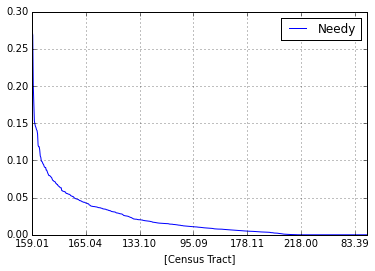

In [19]:
ordered_need = linkage.sort(['Needy'], ascending=0)
ordered_need.plot(x=['Census Tract'], y=['Needy'])

The "elbow" appears at approximately 0.5 - 0.6 "neediness." Let's see how many tracts have a neediness above this value.

In [20]:
np.shape(ordered_need[ordered_need['Needy'] > 0.055])

(67, 8)

In [21]:
ordered_need_top = ordered_need[ordered_need['Needy'] > 0.055]
ordered_need_top.to_csv('agency_tract_filtered.csv', index=False)

# Estimate how many people the top agencies serve
We found that 16 agencies account for 50% of the distributed volume. In this section use the census data and catchment areas to find the approximate number of people these agencies serve.


In [22]:
all_star_agencies = [1189, 1172, 1289, 1064, 1079, 1108, 1065, 1351, 1006, 1146, 1325, 1028, 1381, 1216, 1177, 1178]
select = [i in all_star_agencies for i in linkage["Agency #"].values]
all_star_selector = linkage[select]

In [23]:
print np.shape(all_star_selector)
all_star_selector.head()

(53, 8)


,Census Tract,Agency #,Agency Name,SNAP/Food Stamp Rate,Food Desert Rate,Single Mother Rate,Child Poverty Rate,Needy
5,186.03,1028,Brother Benno Foundation,0.05239961,0.1397315,0.1508325,23.2,0.007321878
18,202.14,1079,Interfaith Community Services,0.1170287,0.06471813,0.143658,44.7,0.00757388
19,206.01,1079,Interfaith Community Services,0.08358209,0.042025,0.2514925,28.8,0.003512538
25,201.09,1289,Mission Vida Nueva Food Bank,0.07807571,0.9949651,0.04416404,20.3,0.0776826
26,57.00,1006,San Diego Rescue Mission,0.05868544,0.7797642,0,NaN,0.04576081


53 census tracts are assigned to these 16 agencies, according to our catchment areas. We will approximate the needy population served by each agency by multipling the tracts' population by their food stamp rate; then aggregating this by agency assignment.

In [24]:
top_distributors = sd_data[['TRACT', 'TotalPopulation', 'SNAP_FdStmp']]
top_distributors.columns = ['Census Tract', 'TotalPopulation', 'SNAP/Food Stamp Rate']
top_distributors['NeedyPopulation'] = top_distributors['TotalPopulation'] * top_distributors['SNAP/Food Stamp Rate']


/Users/jfly/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [25]:
top_distributors.head()

,Census Tract,TotalPopulation,SNAP/Food Stamp Rate,NeedyPopulation
0,50.00,2227,0.218569,486.752428
1,200.28,3479,0.205973,716.580832
2,45.01,2875,0.083200,239.200000
3,48.00,4115,0.133462,549.197282
4,36.01,3250,0.133244,433.041733


In [26]:
top_distributors_need = all_star_selector.join(top_distributors,how='left',lsuffix='Census Tract')

In [27]:
top_distributors_need_grouped = top_distributors_need.groupby(['Agency #'])
top_distributors_need_grouped.sum()

,Census Tract,TotalPopulation,SNAP/Food Stamp Rate,NeedyPopulation
Agency #,,,,
1006,115.00,4673,0.092857,207.436591
1028,1299.64,32935,0.309062,1365.100157
1064,640.43,38481,0.680229,2875.262989
1065,108.38,16380,0.492430,2058.384995
1079,2046.50,46198,0.460884,2293.067680
1146,544.20,15381,0.184038,731.275970
1177,572.04,18170,0.505954,2354.270951
1189,915.09,23206,0.327881,1715.207106
1216,27.00,13115,0.119736,582.622459


Only 10 of the top 16 agencies appear in this aggregration. This is because the missing 6 do not appear in our catchment assignments. This shows a shortcoming of our catchment areas -- top distribution sites do not appear in it.